In [114]:
# Importation des librairies


import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec 
import statsmodels as stat
from statsmodels.tsa.api import Holt
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

In [115]:
#Fonction permattant de calculer la somme des valeurs manquantes et afficher un diagramme en moustaches(boxplot)

def missng_values(df):

    total = df.isnull().sum()   # Calcul du total des valeurs manquantes
    percent = round(df.isnull().sum()/df.isnull().count()*100,2) # Calcul le pourcentage des valeurs 

    missing_data = pd.concat([total,percent],axis =1, keys=['Total','Ratio_of_NA(%)']) 
    type=pd.DataFrame(df[missing_data.index].dtypes, columns=['Types'])
    missing_data=pd.concat([missing_data,type],axis=1)
    missing_data=missing_data.sort_values('Total',ascending=False)
    missing_data.head(20)
    
    print( "le total des valeurs manquantes est", total.sum()) #Afficher la somme total des valeurs manquantes
    print( percent) #afficher le poucentage

    print(missing_data.head(20))
    print()
    print(set(missing_data['Types']))
    print()
    print("---Categorical columns---")
    
    print(missing_data[missing_data['Types']=="object"].index) # Colonnes ayant des variables qualitatives
    print()
    print("---Numerical columns----")
    print(missing_data[missing_data['Types'] !="object"].index)  # Colonnes ayant des variables quantitatives
   
    sns.set_style('whitegrid')
    
    plt.figure(figsize=(16,16)) #Réglage de la taille
    plt.title("Visualisation des valeurs manquantes") #titre 
    sns.heatmap(df.isnull(), cbar=False) #Affichage de la carte thermique

In [116]:
data = pd.read_csv("2016_Building_Energy_Benchmarking.csv", sep=",")

In [117]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [118]:
data.shape

(3376, 46)

In [119]:
data.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

In [120]:
data.ComplianceStatus.value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

In [121]:
data = data.loc[data['ComplianceStatus'] == 'Compliant']

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3211 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3211 non-null   int64  
 1   DataYear                         3211 non-null   int64  
 2   BuildingType                     3211 non-null   object 
 3   PrimaryPropertyType              3211 non-null   object 
 4   PropertyName                     3211 non-null   object 
 5   Address                          3211 non-null   object 
 6   City                             3211 non-null   object 
 7   State                            3211 non-null   object 
 8   ZipCode                          3198 non-null   float64
 9   TaxParcelIdentificationNumber    3211 non-null   object 
 10  CouncilDistrictCode              3211 non-null   int64  
 11  Neighborhood                     3211 non-null   object 
 12  Latitude            

In [123]:
# La colonne 'Comments' est totalement vide, on peut la supprimer tout de suite
data = data.drop(['Comments'], axis=1)

**Variables qualitative**

In [124]:
# Les colonnes object dtypes sont séléctionnés
obj_columns = list(data.select_dtypes(include=['object', 'bool']).columns)

In [125]:
print("Les variables qualitatives sont les suivantes : \n")
for categ in obj_columns :
    print(categ, ":", data[categ].nunique())

Les variables qualitatives sont les suivantes : 

BuildingType : 8
PrimaryPropertyType : 23
PropertyName : 3198
Address : 3189
City : 1
State : 1
TaxParcelIdentificationNumber : 3107
Neighborhood : 19
ListOfAllPropertyUseTypes : 460
LargestPropertyUseType : 55
SecondLargestPropertyUseType : 50
ThirdLargestPropertyUseType : 44
DefaultData : 1
ComplianceStatus : 1
Outlier : 0


**Variables quantitatives**

In [126]:
# Les colonnes float64 et int64 sont séléctionnés
num_columns = list(data.select_dtypes(include=['float64', 'int64']).columns)
print("Les variables quantitatives sont les suivantes : \n")
for num in num_columns :
    print(num)

Les variables quantitatives sont les suivantes : 

OSEBuildingID
DataYear
ZipCode
CouncilDistrictCode
Latitude
Longitude
YearBuilt
NumberofBuildings
NumberofFloors
PropertyGFATotal
PropertyGFAParking
PropertyGFABuilding(s)
LargestPropertyUseTypeGFA
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseTypeGFA
YearsENERGYSTARCertified
ENERGYSTARScore
SiteEUI(kBtu/sf)
SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf)
SourceEUIWN(kBtu/sf)
SiteEnergyUse(kBtu)
SiteEnergyUseWN(kBtu)
SteamUse(kBtu)
Electricity(kWh)
Electricity(kBtu)
NaturalGas(therms)
NaturalGas(kBtu)
TotalGHGEmissions
GHGEmissionsIntensity


**Traitement des doublons**

In [127]:
# Nous vérifions si les données contiennent des bâtiments avec la même identifiante
data.loc[data['OSEBuildingID'].duplicated(keep=False),:]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity


Les doublons n'ont pas été trouvés. Tous les bâtiments ont leur propre ID unique.

**Suppression des colonnes non pertinentes pour l'analyse**

On peut supprimer les variables 'OSEBuildingID', 'DefaultData', 'ComplianceStatus', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'ZipCode' et 'Address' qui ne sont pas pertinantes pour analyse

In [128]:
# Zipcode et Address sont supprimé car la latitude et la longitude sont suffisant pour la localisation

data = data.drop(['OSEBuildingID'], axis=1)
data = data.drop(['ComplianceStatus'], axis=1)
data = data.drop(['CouncilDistrictCode'], axis=1)
data = data.drop(['DefaultData'], axis=1)
data = data.drop(['PropertyName'], axis=1)
data = data.drop(['TaxParcelIdentificationNumber'], axis=1)
data = data.drop(['ZipCode'], axis=1)
data = data.drop(['Address'], axis=1)

**Suppression des colonnes redondantes**

In [129]:
data.dtypes

DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
City                                object
State                               object
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA     float64
YearsENERGYSTARCertified           float64
ENERGYSTARScore                    float64
SiteEUI(kBt

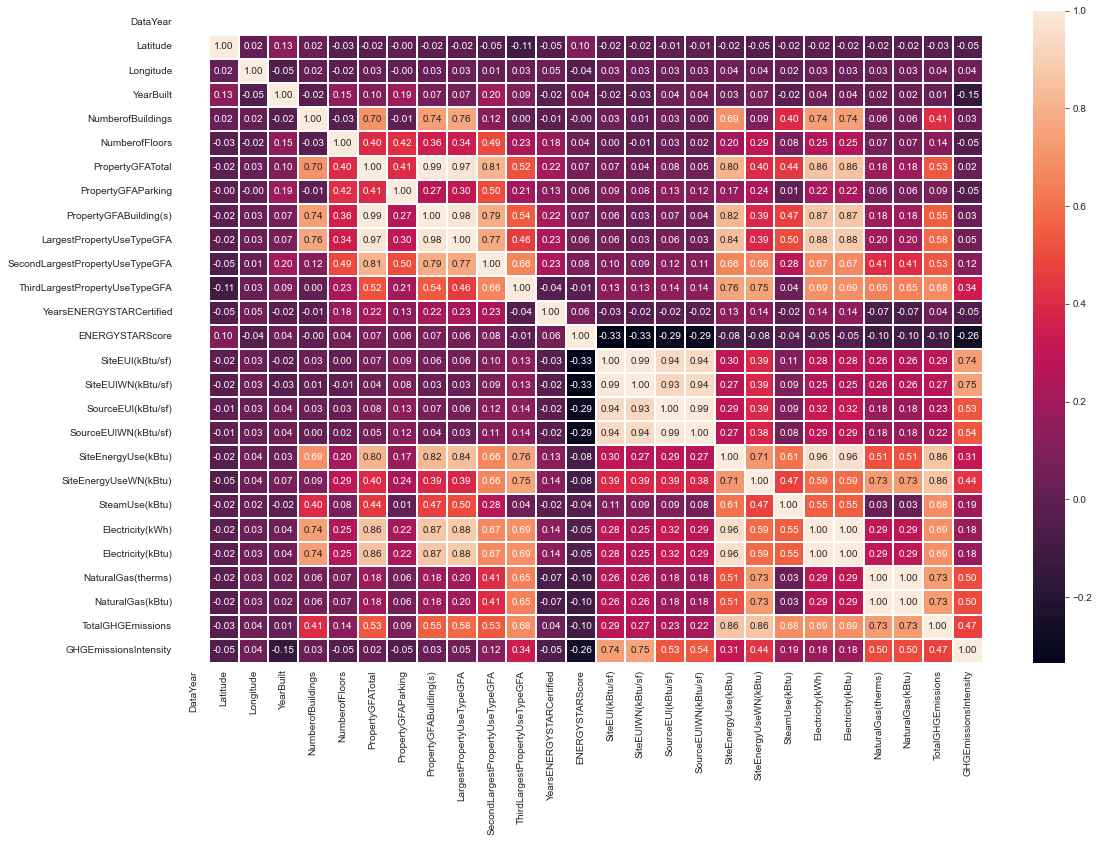

In [130]:
corr = data.corr()

f,ax = plt.subplots(figsize=(18,12))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

Il y a des variables sont fortement corrélées donc certaines variables peuvent être considérées comme redondantes.

Les colonnes suivantes sont redondantes:

"Electricity(kBtu)" vs. "Electricity(kWh)"

"NaturalGas(kBtu)" vs. "NaturalGas(therms)" 

"SourceEUI(kBtu/sf)" vs. "SourceEUIWN(kBtu/sf)"

"Electricity(kBtu)" vs. "Electricity(kWh)"

"PropertyGFATotal" vs. "PropertyGFAParking","PropertyGFABuilding(s)"

In [131]:
# On peut supprimer certaines variables
data = data.drop(columns=['Electricity(kWh)', 'NaturalGas(therms)','SourceEUIWN(kBtu/sf)', 'PropertyGFAParking', 'Electricity(kWh)', 'PropertyGFABuilding(s)'])

**Traitement des valeurs aberrantes**

In [132]:
data.describe()

,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,...,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3211.0,3211.000000,3211.000000,3211.000000,3208.000000,3211.000000,3.211000e+03,3.196000e+03,1647.000000,583.000000,...,3211.000000,3210.000000,3207.000000,3.211000e+03,3.210000e+03,3.207000e+03,3.207000e+03,3.207000e+03,3207.000000,3207.000000
mean,2016.0,47.624544,-122.335136,1968.739645,1.110973,4.804734,9.579423e+04,7.945189e+04,28235.887248,11865.633617,...,55.624229,57.950062,136.583536,5.533766e+06,5.390987e+06,2.853587e+05,3.800520e+06,1.387511e+06,122.211886,1.189146
std,0.0,0.047004,0.026574,33.163544,2.158983,5.591453,2.227902e+05,2.055745e+05,52296.359208,29623.952143,...,56.722463,57.615619,139.761916,2.211048e+07,1.628833e+07,4.005355e+06,1.518433e+07,6.866490e+06,551.534876,1.843667
min,2016.0,47.502240,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,5.656000e+03,0.000000,0.000000,...,1.400000,0.000000,0.000000,5.713320e+04,0.000000e+00,0.000000e+00,-1.154170e+05,0.000000e+00,-0.800000,-0.020000
25%,2016.0,47.601050,-122.350425,1948.000000,1.000000,2.000000,2.830000e+04,2.498950e+04,5000.000000,2299.000000,...,28.100000,29.500000,75.549999,9.368353e+05,9.869139e+05,0.000000e+00,6.429560e+05,0.000000e+00,9.640000,0.210000
50%,2016.0,47.618910,-122.332630,1975.000000,1.000000,4.000000,4.379400e+04,3.900000e+04,10800.000000,5149.000000,...,39.299999,41.400002,97.699997,1.808401e+06,1.904452e+06,0.000000e+00,1.187175e+06,3.194000e+05,33.920000,0.610000
75%,2016.0,47.656745,-122.320200,1997.000000,1.000000,5.000000,9.154000e+04,7.676675e+04,26770.000000,10280.000000,...,61.500000,65.475000,146.600006,4.266934e+06,4.426424e+06,0.000000e+00,2.888685e+06,1.183018e+06,94.385000,1.380000
max,2016.0,47.733870,-122.260280,2015.000000,111.000000,99.000000,9.320156e+06,9.320156e+06,639931.000000,459748.000000,...,834.400024,834.400024,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000


Il y a quelques valeurs négatives qui doivent être traitées. La variable Longitude est négative et correspond à une longitude Ouest (ce n'est pas aberrant)

In [133]:
data.min()

C:\Users\lemis\AppData\Local\Temp/ipykernel_19176/927168777.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.min()


DataYear                                          2016
BuildingType                                    Campus
PrimaryPropertyType                Distribution Center
City                                           Seattle
State                                               WA
Neighborhood                                   BALLARD
Latitude                                      47.50224
Longitude                                   -122.41425
YearBuilt                                         1900
NumberofBuildings                                  0.0
NumberofFloors                                       0
PropertyGFATotal                                 11285
LargestPropertyUseTypeGFA                       5656.0
SecondLargestPropertyUseTypeGFA                    0.0
ThirdLargestPropertyUseTypeGFA                     0.0
YearsENERGYSTARCertified                        2007.0
ENERGYSTARScore                                    1.0
SiteEUI(kBtu/sf)                                   1.4
SiteEUIWN(

In [134]:
data[data['Electricity(kBtu)']<0]

,DataYear,BuildingType,PrimaryPropertyType,City,State,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,...,SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3206,2016,NonResidential,Small- and Mid-Sized Office,Seattle,WA,CENTRAL,47.61432,-122.31257,2013,1.0,...,5.0,2.0,342726.0938,240132.0938,0.0,-115417.0,0.0,NaN,-0.8,-0.02


In [135]:
index_to_drop=data[data['Electricity(kBtu)']<0].index
data.drop(index_to_drop, inplace=True)

In [136]:
data.min()

C:\Users\lemis\AppData\Local\Temp/ipykernel_19176/927168777.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.min()


DataYear                                          2016
BuildingType                                    Campus
PrimaryPropertyType                Distribution Center
City                                           Seattle
State                                               WA
Neighborhood                                   BALLARD
Latitude                                      47.50224
Longitude                                   -122.41425
YearBuilt                                         1900
NumberofBuildings                                  0.0
NumberofFloors                                       0
PropertyGFATotal                                 11285
LargestPropertyUseTypeGFA                       5656.0
SecondLargestPropertyUseTypeGFA                    0.0
ThirdLargestPropertyUseTypeGFA                     0.0
YearsENERGYSTARCertified                        2007.0
ENERGYSTARScore                                    1.0
SiteEUI(kBtu/sf)                                   1.4
SiteEUIWN(

**Traitement des valeurs manquantes**

le total des valeurs manquantes est 15557
DataYear                             0.00
BuildingType                         0.00
PrimaryPropertyType                  0.00
City                                 0.00
State                                0.00
Neighborhood                         0.00
Latitude                             0.00
Longitude                            0.00
YearBuilt                            0.00
NumberofBuildings                    0.09
NumberofFloors                       0.00
PropertyGFATotal                     0.00
ListOfAllPropertyUseTypes            0.12
LargestPropertyUseType               0.47
LargestPropertyUseTypeGFA            0.47
SecondLargestPropertyUseType        48.69
SecondLargestPropertyUseTypeGFA     48.69
ThirdLargestPropertyUseType         81.84
ThirdLargestPropertyUseTypeGFA      81.84
YearsENERGYSTARCertified            96.32
ENERGYSTARScore                     25.30
SiteEUI(kBtu/sf)                     0.00
SiteEUIWN(kBtu/sf)                

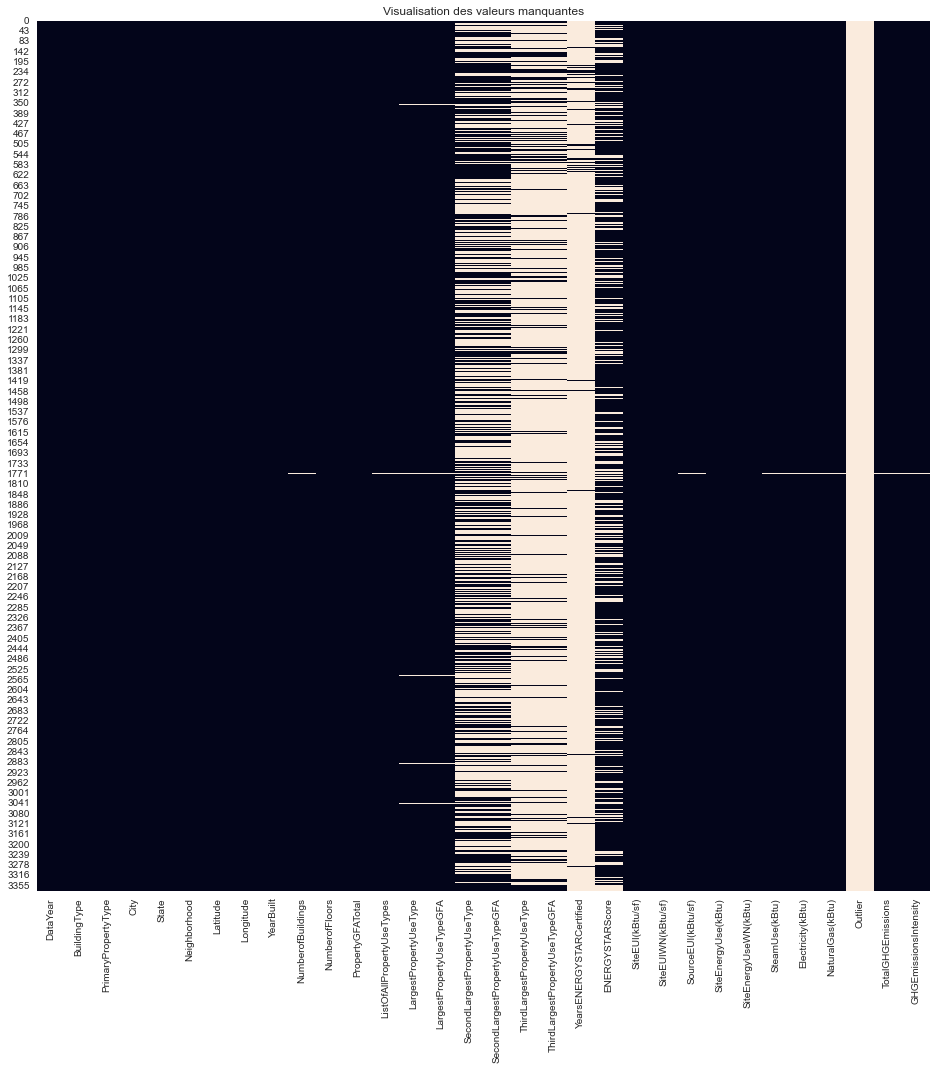

In [137]:
missng_values(data)

In [138]:
# La colonne 'Outlier' et 'YearsENERGYSTARCertified' sont presque totalement vides, on peut les supprimer
data = data.drop(['Outlier'], axis=1)
data = data.drop(['YearsENERGYSTARCertified'], axis=1)

In [139]:
data["SecondLargestPropertyUseType"].unique()

array([nan, 'Parking', 'Office', 'Restaurant', 'K-12 School',
       'Laboratory', 'Refrigerated Warehouse',
       'Non-Refrigerated Warehouse', 'Other - Education',
       'Vocational School', 'Retail Store',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Other - Entertainment/Public Assembly', 'Data Center',
       'Swimming Pool', 'Other', 'Courthouse', 'Residence Hall/Dormitory',
       'Distribution Center', 'Self-Storage Facility', 'Other - Services',
       'Movie Theater', 'Supermarket/Grocery Store', 'Medical Office',
       'Other - Recreation', 'Convenience Store without Gas Station',
       'Performing Arts', 'College/University', 'Other - Restaurant/Bar',
       'Adult Education', 'Enclosed Mall', 'Multifamily Housing',
       'Bar/Nightclub', 'Financial Office',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Manufacturing/Industrial Plant', 'Other - Lodging/Residential',
       'Bank Branch', 'Food Service', 'Worship Facility',


In [140]:
data["ThirdLargestPropertyUseType"].unique()

array([nan, 'Restaurant', 'Swimming Pool', 'Data Center', 'Office',
       'Retail Store', 'Other - Entertainment/Public Assembly',
       'Non-Refrigerated Warehouse', 'Other', 'Distribution Center',
       'Food Service', 'Other - Services', 'Medical Office', 'Parking',
       'Other - Utility', 'Other - Lodging/Residential', 'K-12 School',
       'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Pre-school/Daycare', 'Convenience Store without Gas Station',
       'Financial Office', 'Other - Restaurant/Bar', 'Other - Education',
       'Multifamily Housing', 'Laboratory', 'Bank Branch', 'Hotel',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Other - Recreation', 'Self-Storage Facility',
       'Other - Technology/Science', 'Refrigerated Warehouse',
       'Fast Food Restaurant', 'Bar/Nightclub',
       'Manufacturing/Industrial Plant', 'Food Sales',
       'Supermarket/Grocery Store', 'Other/Specialty Hospital',
       'Worship Facility', 'Stri

Les colonnes 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType' et 'ThirdLargestPropertyUseTypeGFA' contiennent beaucoup de valeurs manquantes. On considère que les bâtiments dont les valeurs sont manquantes pour ces variables ne possèdent pas de deuxième et troisième utilisation donc on ajoute une catégorie aux types d'utilisation et on remplace les valeurs de surface par 0.

In [141]:
# Les valeurs manquantes sont remplacés par une catégorie supplémentaire
data["SecondLargestPropertyUseType"].fillna("unknown", inplace=True)

# Les valeurs manquantes sont remplacés par 0
data["SecondLargestPropertyUseTypeGFA"].fillna(0, inplace=True)

In [142]:
# Les valeurs manquantes sont remplacés par une catégorie supplémentaire
data["ThirdLargestPropertyUseType"].fillna("unknown", inplace=True)

# Les valeurs manquantes sont remplacés par 0
data["ThirdLargestPropertyUseTypeGFA"].fillna(0, inplace=True)

In [143]:
data.shape

(3210, 30)

le total des valeurs manquantes est 875
DataYear                            0.00
BuildingType                        0.00
PrimaryPropertyType                 0.00
City                                0.00
State                               0.00
Neighborhood                        0.00
Latitude                            0.00
Longitude                           0.00
YearBuilt                           0.00
NumberofBuildings                   0.09
NumberofFloors                      0.00
PropertyGFATotal                    0.00
ListOfAllPropertyUseTypes           0.12
LargestPropertyUseType              0.47
LargestPropertyUseTypeGFA           0.47
SecondLargestPropertyUseType        0.00
SecondLargestPropertyUseTypeGFA     0.00
ThirdLargestPropertyUseType         0.00
ThirdLargestPropertyUseTypeGFA      0.00
ENERGYSTARScore                    25.30
SiteEUI(kBtu/sf)                    0.00
SiteEUIWN(kBtu/sf)                  0.03
SourceEUI(kBtu/sf)                  0.12
SiteEnergyUse(kBt

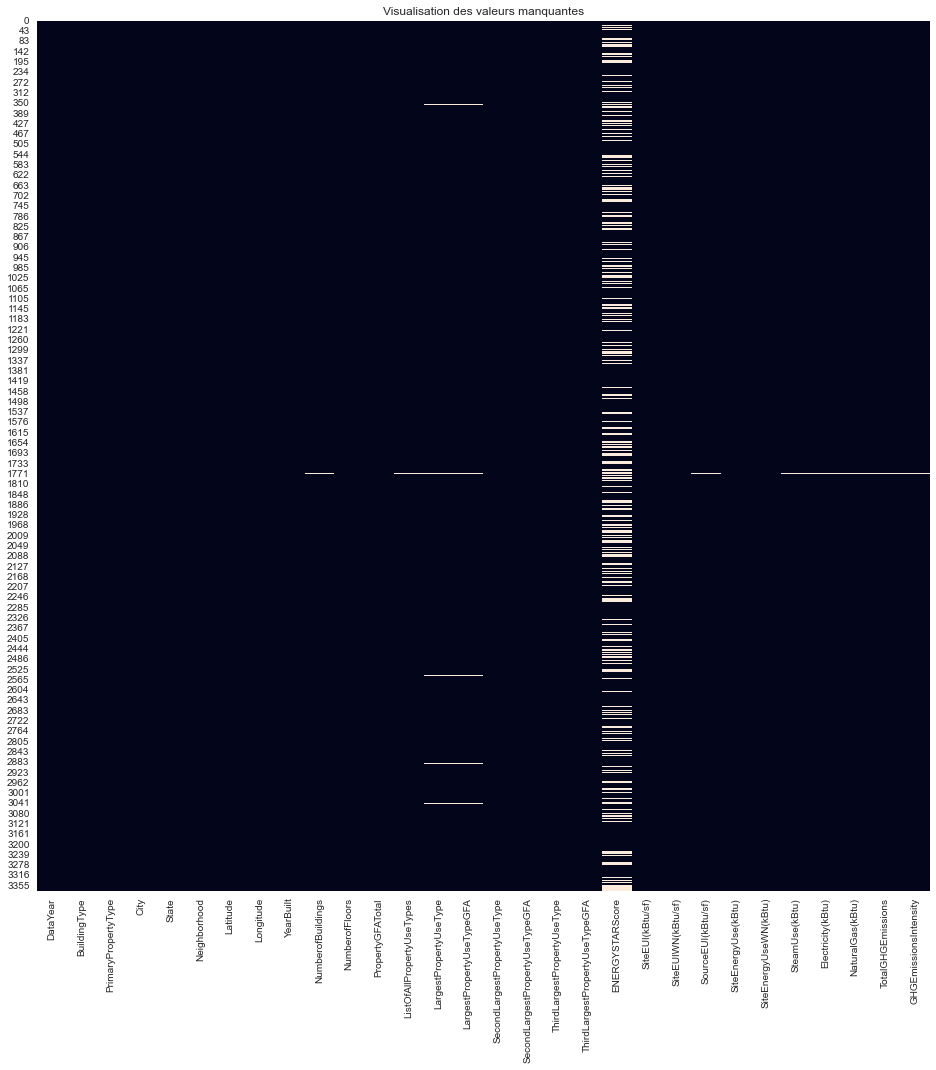

In [144]:
missng_values(data)

Le nombre de NaN pour la variable ENERGYSTARScore est assez élevé. Si nous supprimons les valeurs manquantes, nous allons perdre beaucoup d'informations. Nous allons remplir le NaN par des valeurs prédites.

Le nombre de NaN pour le reste des variables est assez faible. On peut donc ecarter ces observations

In [145]:
data = data.loc[data['LargestPropertyUseTypeGFA'].notnull()]
data = data.loc[data['LargestPropertyUseType'].notnull()]
data = data.loc[data['ListOfAllPropertyUseTypes'].notnull()]
data = data.loc[data['TotalGHGEmissions'].notnull()]
data = data.loc[data['NaturalGas(kBtu)'].notnull()]
data = data.loc[data['Electricity(kBtu)'].notnull()]
data = data.loc[data['SteamUse(kBtu)'].notnull()]
data = data.loc[data['GHGEmissionsIntensity'].notnull()]
data = data.loc[data['SourceEUI(kBtu/sf)'].notnull()]
data = data.loc[data['NumberofBuildings'].notnull()]
data = data.loc[data['SiteEnergyUseWN(kBtu)'].notnull()]

le total des valeurs manquantes est 804
DataYear                            0.00
BuildingType                        0.00
PrimaryPropertyType                 0.00
City                                0.00
State                               0.00
Neighborhood                        0.00
Latitude                            0.00
Longitude                           0.00
YearBuilt                           0.00
NumberofBuildings                   0.00
NumberofFloors                      0.00
PropertyGFATotal                    0.00
ListOfAllPropertyUseTypes           0.00
LargestPropertyUseType              0.00
LargestPropertyUseTypeGFA           0.00
SecondLargestPropertyUseType        0.00
SecondLargestPropertyUseTypeGFA     0.00
ThirdLargestPropertyUseType         0.00
ThirdLargestPropertyUseTypeGFA      0.00
ENERGYSTARScore                    25.17
SiteEUI(kBtu/sf)                    0.00
SiteEUIWN(kBtu/sf)                  0.00
SourceEUI(kBtu/sf)                  0.00
SiteEnergyUse(kBt

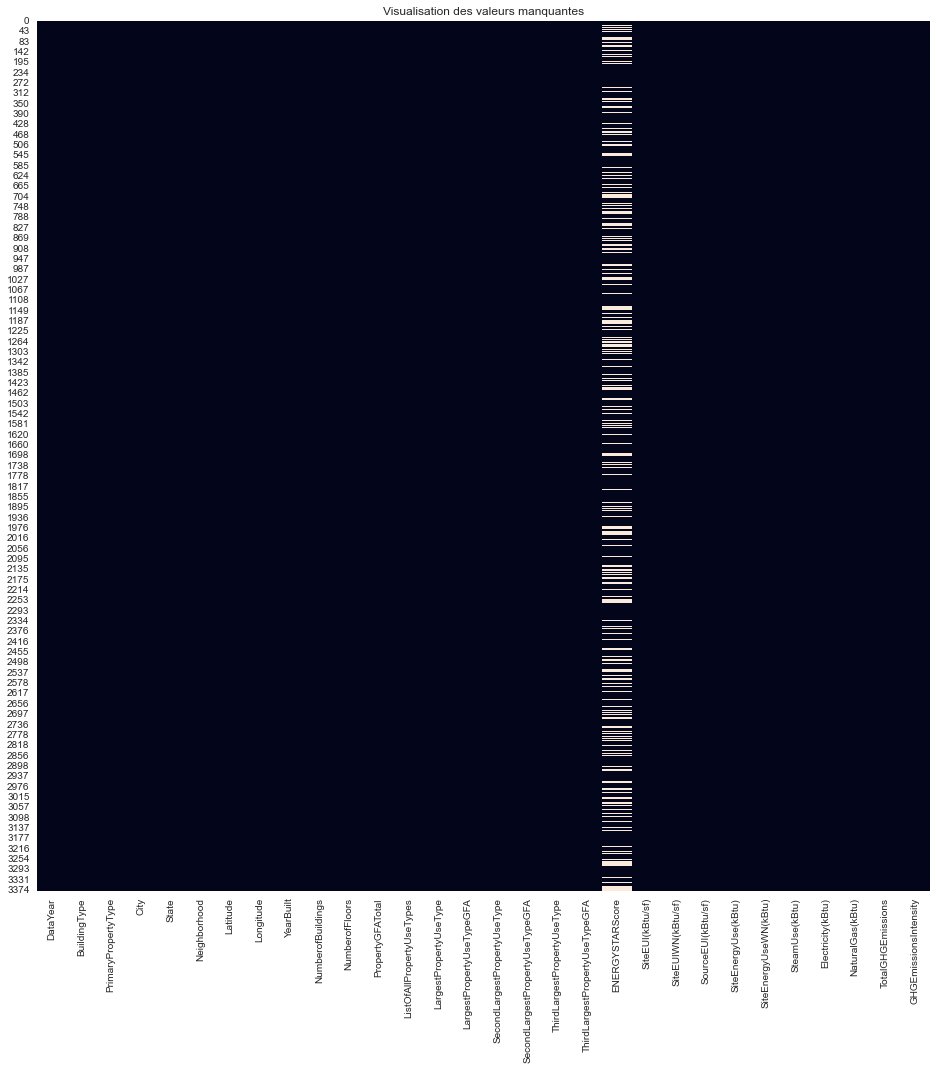

In [146]:
missng_values(data)

In [147]:
data["DataYear"].unique()

array([2016], dtype=int64)

Toutes les données sont collectées en 2016, on peut supprimer la variable 'DataYear'

In [148]:
data = data.drop(['DataYear'], axis=1)

In [149]:
data["City"].unique()

array(['Seattle'], dtype=object)

In [150]:
data["State"].unique()

array(['WA'], dtype=object)

In [151]:
data = data.drop(['City'], axis=1)
data = data.drop(['State'], axis=1)

**Age de l'immeuble**

L'age de l'immeuble au moment du relevé sera plus représentatif que l'année de construction.

La variable "building_age" est créé et la variables "YearBuilt" est supprimées

In [152]:
data["building_age"] = 2016 - data["YearBuilt"]
data = data.drop("YearBuilt", axis=1)

**encodage du type d'immeuble**

On utilise pour cela un OneHotEncoder sur la variable BuidingType

In [153]:
data["BuildingType"].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'Campus', 'SPS-District K-12', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [154]:
data = data[data["BuildingType"].isin(['NonResidential', 'Nonresidential COS', 'Nonresidential WA'])]

In [155]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
transformed = encoder.fit_transform(data[['BuildingType']])
#Vérification que les colonnes n'existes pas 
test = [ col in data.columns for col in encoder.categories_[0] ]
if np.any(test) : 
    print("Des colonnes existent déjà : ")
    print(encoder.categories_[0][test])
else :
    print("Les colonnes suivantes sont créées :")
    print(encoder.categories_[0])
data[encoder.categories_[0]] = transformed.toarray()

Les colonnes suivantes sont créées :
['NonResidential' 'Nonresidential COS' 'Nonresidential WA']


le total des valeurs manquantes est 528
BuildingType                        0.00
PrimaryPropertyType                 0.00
Neighborhood                        0.00
Latitude                            0.00
Longitude                           0.00
NumberofBuildings                   0.00
NumberofFloors                      0.00
PropertyGFATotal                    0.00
ListOfAllPropertyUseTypes           0.00
LargestPropertyUseType              0.00
LargestPropertyUseTypeGFA           0.00
SecondLargestPropertyUseType        0.00
SecondLargestPropertyUseTypeGFA     0.00
ThirdLargestPropertyUseType         0.00
ThirdLargestPropertyUseTypeGFA      0.00
ENERGYSTARScore                    35.01
SiteEUI(kBtu/sf)                    0.00
SiteEUIWN(kBtu/sf)                  0.00
SourceEUI(kBtu/sf)                  0.00
SiteEnergyUse(kBtu)                 0.00
SiteEnergyUseWN(kBtu)               0.00
SteamUse(kBtu)                      0.00
Electricity(kBtu)                   0.00
NaturalGas(kBtu) 

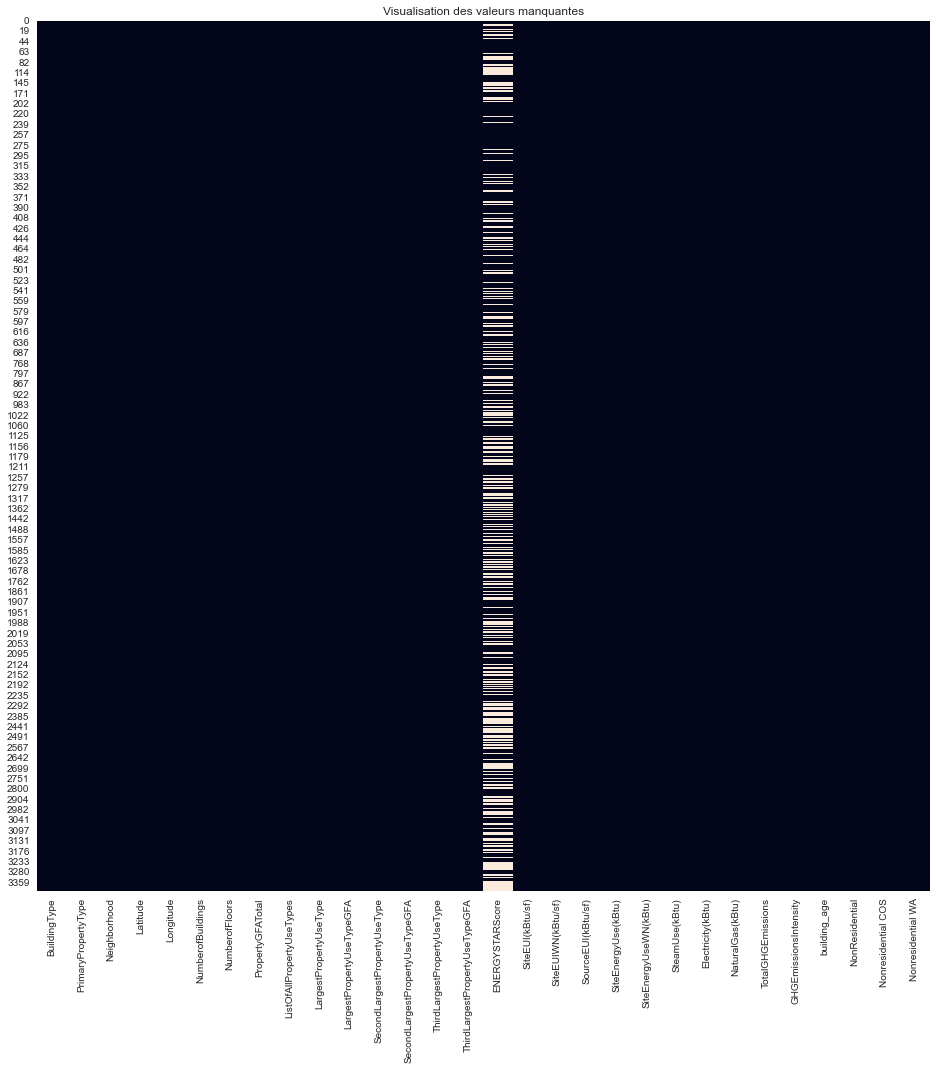

In [156]:
missng_values(data)

Dans le Dataset avec des valeurs manquantes dans pour la variable ENERGYSTARScore, on va imputer les valeurs.
Deux méthodes seront testées : impuation par la moyenne et par les KNN.


**Impuation par la moyenne**

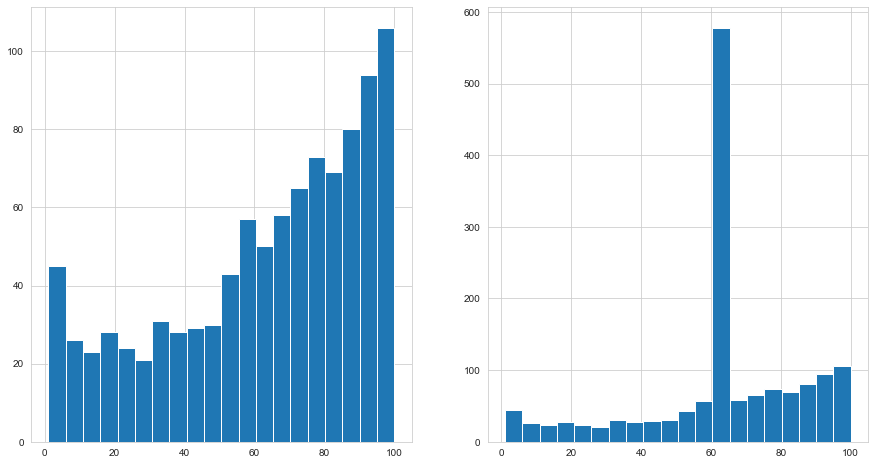

In [157]:
new_energystar_mean = data["ENERGYSTARScore"].copy(deep=True)
new_energystar_mean.loc[pd.isnull(new_energystar_mean)] = new_energystar_mean.mean()

# Comparaison de la nouvelle distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
axs[0].hist(data["ENERGYSTARScore"], bins=20)
axs[1].hist(new_energystar_mean, bins=20)
plt.show()

La distribution obtenue par une imputation par la moyenne est fortement différente de la distribution initiale,
cela signifie que la variable n'est plus représentative de l'échantillon.

**impuation par KNN**

In [158]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.impute import KNNImputer

In [159]:
#completer les NA de ENERGYSTARScore
df_ENERGYSTARScore_not_null = data[data['ENERGYSTARScore'].notnull()]
df_ENERGYSTARScore_null = data[data['ENERGYSTARScore'].isnull()]

In [160]:
df_ENERGYSTARScore_not_null.shape, df_ENERGYSTARScore_null.shape

((980, 30), (528, 30))

In [161]:
xtrain, xtest, ytrain, ytest = train_test_split(df_ENERGYSTARScore_not_null[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)']], df_ENERGYSTARScore_not_null[['ENERGYSTARScore']], train_size=0.8)
print(f"xtrain {xtrain.shape}")
print(f"xtest {xtest.shape}")
print(f"ytrain {ytrain.shape}")
print(f"ytest {ytest.shape}")

xtrain (784, 8)
xtest (196, 8)
ytrain (784, 1)
ytest (196, 1)


[-0.6527477450832191, -0.43035244690694285, -0.2034112291514678, -0.10891931593372295, -0.09476903488612387, -0.07268327429033383, -0.09588566604529114, -0.08743645429389724, -0.06778553424603517, -0.05675457744616641, -0.038067953208575034, -0.057846171709884375, -0.06668473420791488, -0.061887720078490416, -0.03941392520910836, -0.041483339178465695, -0.04338733670267536, -0.049053333428977774, -0.05212016845603129, -0.05870889719945582, -0.060170870385375386, -0.059042672081267566, -0.05255202056553432, -0.052328887472149255, -0.05257258811962373, -0.04908784571761071, -0.04777450886959489, -0.04824321296357792, -0.04430993326960442, -0.04584319753310084, -0.042084246289949556, -0.04170888927503125, -0.04366328347277437, -0.04533019715322939, -0.04804017231950741, -0.05682634222886063, -0.05250841200175271, -0.05363846252124049, -0.05659350596153567, -0.05184491766003929, -0.05663201617907232, -0.05507482943393849, -0.06197778343339855, -0.06581339700656774, -0.0582442021393168, -0.

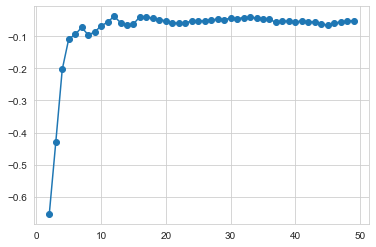

In [162]:
from sklearn.metrics import accuracy_score
errors = []
for k in range(2,50):
    knn = KNeighborsRegressor(k)
    errors.append(knn.fit(xtrain, ytrain).score(xtest, ytest))
print(errors)
plt.plot(range(2,50), errors, 'o-')
plt.show()

In [163]:
k = 14
knn = KNeighborsRegressor(k).fit(xtrain, ytrain)
df_ENERGYSTARScore_null['ENERGYSTARScore'] = knn.predict(df_ENERGYSTARScore_null[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)']])

C:\Users\lemis\AppData\Local\Temp/ipykernel_19176/3344220899.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ENERGYSTARScore_null['ENERGYSTARScore'] = knn.predict(df_ENERGYSTARScore_null[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)']])


In [164]:
data_test = pd.concat([df_ENERGYSTARScore_null, df_ENERGYSTARScore_not_null])

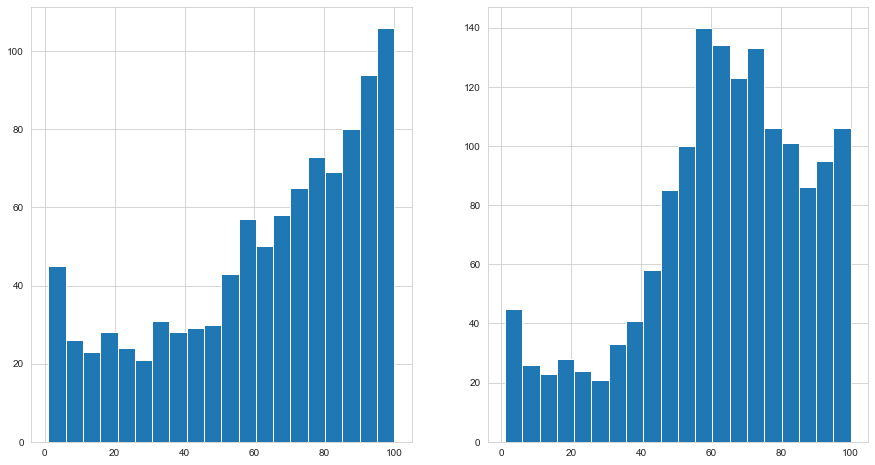

In [165]:
# Comparaison de la nouvelle distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
axs[0].hist(data["ENERGYSTARScore"], bins=20)
axs[1].hist(data_test['ENERGYSTARScore'], bins=20)
plt.show()

La forme de la distribution est moins modifiée. On peut concerver ces valeurs

le total des valeurs manquantes est 0
BuildingType                       0.0
PrimaryPropertyType                0.0
Neighborhood                       0.0
Latitude                           0.0
Longitude                          0.0
NumberofBuildings                  0.0
NumberofFloors                     0.0
PropertyGFATotal                   0.0
ListOfAllPropertyUseTypes          0.0
LargestPropertyUseType             0.0
LargestPropertyUseTypeGFA          0.0
SecondLargestPropertyUseType       0.0
SecondLargestPropertyUseTypeGFA    0.0
ThirdLargestPropertyUseType        0.0
ThirdLargestPropertyUseTypeGFA     0.0
ENERGYSTARScore                    0.0
SiteEUI(kBtu/sf)                   0.0
SiteEUIWN(kBtu/sf)                 0.0
SourceEUI(kBtu/sf)                 0.0
SiteEnergyUse(kBtu)                0.0
SiteEnergyUseWN(kBtu)              0.0
SteamUse(kBtu)                     0.0
Electricity(kBtu)                  0.0
NaturalGas(kBtu)                   0.0
TotalGHGEmissions         

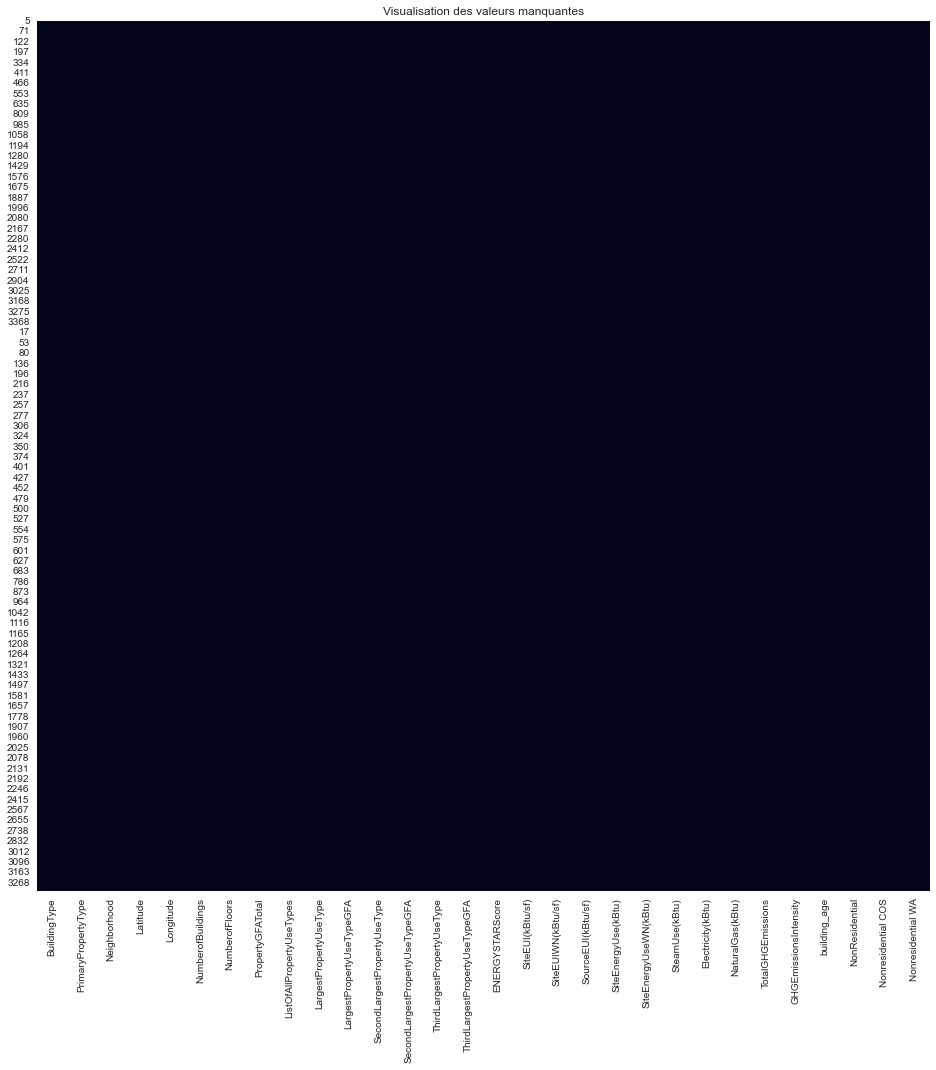

In [166]:
missng_values(data_test)

In [167]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1508 entries, 5 to 3347
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1508 non-null   object 
 1   PrimaryPropertyType              1508 non-null   object 
 2   Neighborhood                     1508 non-null   object 
 3   Latitude                         1508 non-null   float64
 4   Longitude                        1508 non-null   float64
 5   NumberofBuildings                1508 non-null   float64
 6   NumberofFloors                   1508 non-null   int64  
 7   PropertyGFATotal                 1508 non-null   int64  
 8   ListOfAllPropertyUseTypes        1508 non-null   object 
 9   LargestPropertyUseType           1508 non-null   object 
 10  LargestPropertyUseTypeGFA        1508 non-null   float64
 11  SecondLargestPropertyUseType     1508 non-null   object 
 12  SecondLargestPropert

In [168]:
data_test['Neighborhood'].value_counts()

DOWNTOWN                  342
GREATER DUWAMISH          321
LAKE UNION                141
MAGNOLIA / QUEEN ANNE     140
NORTHEAST                 115
EAST                      114
NORTHWEST                  71
BALLARD                    56
NORTH                      49
CENTRAL                    39
DELRIDGE                   33
SOUTHWEST                  31
SOUTHEAST                  30
North                       8
Ballard                     5
Delridge                    4
Central                     4
Northwest                   4
DELRIDGE NEIGHBORHOODS      1
Name: Neighborhood, dtype: int64

In [169]:
data_test.head()

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ListOfAllPropertyUseTypes,LargestPropertyUseType,...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,building_age,NonResidential,Nonresidential COS,Nonresidential WA
5,Nonresidential COS,Other,DOWNTOWN,47.61623,-122.33657,1.0,2,97288,Police Station,Police Station,...,12581712.0,0.000,7371434.0,4715182.0,301.81,3.10,17,0.0,1.0,0.0
7,NonResidential,Other,DOWNTOWN,47.61327,-122.33136,1.0,8,102761,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,...,7067881.5,2276286.500,3636655.0,385189.0,221.51,2.16,90,1.0,0.0,0.0
15,Nonresidential COS,Other,DOWNTOWN,47.60649,-122.33297,1.0,11,412000,"Data Center, Library, Parking",Library,...,18706912.0,737559.500,17851297.0,0.0,181.38,0.44,12,0.0,1.0,0.0
16,NonResidential,Other,DOWNTOWN,47.60546,-122.33279,1.0,6,103911,"Fitness Center/Health Club/Gym, Office, Swimmi...",Fitness Center/Health Club/Gym,...,10192124.0,4592347.500,4453868.0,910180.0,433.86,4.18,86,1.0,0.0,0.0
18,NonResidential,Mixed Use Property,DOWNTOWN,47.60515,-122.33159,1.0,5,57452,"Office, Other, Other - Lodging/Residential, Re...",Social/Meeting Hall,...,7877219.0,1776201.875,3764791.0,2065091.0,273.02,4.75,109,1.0,0.0,0.0


In [170]:
data_test['LargestPropertyUseType'].unique()

array(['Police Station', 'Other - Entertainment/Public Assembly',
       'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Other', 'College/University', 'Automobile Dealership', 'Hotel',
       'Office', 'Self-Storage Facility', 'Non-Refrigerated Warehouse',
       'Other - Mall', 'Medical Office', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Other/Specialty Hospital',
       'Distribution Center', 'Parking', 'Multifamily Housing',
       'Senior Care Community', 'Restaurant', 'Laboratory',
       'Retail Store', 'Urgent Care/Clinic/Other Outpatient',
       'Other - Services', 'Strip Mall', 'Refrigerated Warehouse',
       'Manufacturing/Industrial Plant', 'Other - Recreation',
       'Lifestyle Center', 'Other - Public Services', 'Fire Station',
       'Residence Hall/Dormitory', 'Performing Arts',
       'Supermarket/Grocery Store', 'Residential Care Facility',
       'Other - Education', 'Other 

In [171]:
data_test[(data_test['LargestPropertyUseType'] == 'Parking')|(data_test['SecondLargestPropertyUseType'] == 'Parking')| (data_test['ThirdLargestPropertyUseType'] == 'Parking')].index

Int64Index([  15,   26,   65,   90,  149,  155,  163,  164,  166,  223,
            ...
            3216, 3221, 3228, 3276, 3281, 3320, 3324, 3329, 3337, 3347],
           dtype='int64', length=396)

In [172]:
data_test = data_test.reset_index(drop = True)

In [173]:
data_test['contain_parking'] = pd.Series(data_test.index).apply(lambda x: 1 if x in data_test[(data_test['LargestPropertyUseType'] == 'Parking')|(data_test['SecondLargestPropertyUseType'] == 'Parking')| (data_test['ThirdLargestPropertyUseType'] == 'Parking')].index else 0)

In [174]:
pd.Series(data_test.index).apply(lambda x: 1 if x in data_test[(data_test['LargestPropertyUseType'] == 'Parking')|(data_test['SecondLargestPropertyUseType'] == 'Parking')| (data_test['ThirdLargestPropertyUseType'] == 'Parking')].index else 0)

0       0
1       0
2       1
3       0
4       0
       ..
1503    1
1504    1
1505    0
1506    0
1507    1
Length: 1508, dtype: int64

In [175]:
data_test

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ListOfAllPropertyUseTypes,LargestPropertyUseType,...,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,building_age,NonResidential,Nonresidential COS,Nonresidential WA,contain_parking
0,Nonresidential COS,Other,DOWNTOWN,47.61623,-122.33657,1.0,2,97288,Police Station,Police Station,...,0.000,7371434.0,4715182.0,301.81,3.10,17,0.0,1.0,0.0,0
1,NonResidential,Other,DOWNTOWN,47.61327,-122.33136,1.0,8,102761,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,...,2276286.500,3636655.0,385189.0,221.51,2.16,90,1.0,0.0,0.0,0
2,Nonresidential COS,Other,DOWNTOWN,47.60649,-122.33297,1.0,11,412000,"Data Center, Library, Parking",Library,...,737559.500,17851297.0,0.0,181.38,0.44,12,0.0,1.0,0.0,1
3,NonResidential,Other,DOWNTOWN,47.60546,-122.33279,1.0,6,103911,"Fitness Center/Health Club/Gym, Office, Swimmi...",Fitness Center/Health Club/Gym,...,4592347.500,4453868.0,910180.0,433.86,4.18,86,1.0,0.0,0.0,0
4,NonResidential,Mixed Use Property,DOWNTOWN,47.60515,-122.33159,1.0,5,57452,"Office, Other, Other - Lodging/Residential, Re...",Social/Meeting Hall,...,1776201.875,3764791.0,2065091.0,273.02,4.75,109,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,Nonresidential COS,Large Office,LAKE UNION,47.62251,-122.33390,1.0,13,536697,"Office, Parking, Retail Store",Office,...,0.000,9925769.0,3313279.0,245.16,0.46,2,0.0,1.0,0.0,1
1504,NonResidential,Hotel,LAKE UNION,47.65476,-122.34732,1.0,4,126823,"Hotel, Parking, Swimming Pool",Hotel,...,0.000,4115620.0,1926779.0,131.02,1.03,2,1.0,0.0,0.0,1
1505,NonResidential,Warehouse,GREATER DUWAMISH,47.54425,-122.31776,1.0,1,52085,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,...,0.000,732803.0,2873052.0,157.70,3.03,61,1.0,0.0,0.0,0
1506,NonResidential,Small- and Mid-Sized Office,GREATER DUWAMISH,47.53161,-122.29944,1.0,2,24990,Office,Office,...,0.000,2167029.0,2253621.0,134.80,5.39,87,1.0,0.0,0.0,0


In [176]:
data_test['contain_parking'].value_counts()

0    1112
1     396
Name: contain_parking, dtype: int64

In [177]:
data_test.shape

(1508, 31)

In [178]:
data_test['parking_area_1'] = np.where(data_test['LargestPropertyUseType'] == 'Parking', data_test['LargestPropertyUseTypeGFA'], 0)

In [179]:
data_test[data_test['parking_area_1'] > 0]

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ListOfAllPropertyUseTypes,LargestPropertyUseType,...,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,building_age,NonResidential,Nonresidential COS,Nonresidential WA,contain_parking,parking_area_1
47,NonResidential,Other,NORTH,47.70281,-122.32532,1.0,6,419848,"Fast Food Restaurant, Medical Office, Movie Th...",Parking,...,6995246.0,2139716.0,162.41,0.39,8,1.0,0.0,0.0,1,335109.0
60,NonResidential,Other,LAKE UNION,47.62323,-122.33028,1.0,5,141131,"Office, Parking, Personal Services (Health/Bea...",Parking,...,3085813.0,0.0,21.51,0.15,7,1.0,0.0,0.0,1,74831.0
63,NonResidential,Other,DOWNTOWN,47.61164,-122.33446,1.0,6,147852,"Office, Other - Restaurant/Bar, Parking, Retai...",Parking,...,7122619.0,2548999.0,185.03,1.25,20,1.0,0.0,0.0,1,64821.0
64,NonResidential,Other,DOWNTOWN,47.61185,-122.33421,0.0,4,267335,"Movie Theater, Other - Restaurant/Bar, Parking",Parking,...,5169902.0,2103253.0,147.75,0.55,20,1.0,0.0,0.0,1,166960.0
77,NonResidential,Other,LAKE UNION,47.64942,-122.35024,1.0,3,280252,"Office, Parking, Retail Store",Parking,...,11521701.0,0.0,80.32,0.29,15,1.0,0.0,0.0,1,156312.0
83,NonResidential,Other,BALLARD,47.66233,-122.37480,1.0,5,322869,"Parking, Retail Store",Parking,...,10708106.0,6377238.0,413.35,1.28,8,1.0,0.0,0.0,1,182454.0
93,NonResidential,Other,NORTHWEST,47.70887,-122.33494,1.0,3,161789,"Medical Office, Parking",Parking,...,6947606.0,16010.0,49.28,0.30,11,1.0,0.0,0.0,1,91935.0
97,NonResidential,Mixed Use Property,LAKE UNION,47.63451,-122.32505,0.0,5,251827,"Laboratory, Office, Parking",Parking,...,29154854.0,17947572.0,1156.45,4.59,14,1.0,0.0,0.0,1,113318.0
110,NonResidential,Mixed Use Property,GREATER DUWAMISH,47.58924,-122.33566,1.0,6,286000,"Distribution Center, Office, Other, Other - Re...",Parking,...,63822136.0,13053.0,445.62,1.56,7,1.0,0.0,0.0,1,111774.0
116,NonResidential,Other,DOWNTOWN,47.61234,-122.34897,1.0,6,275982,"Office, Parking",Parking,...,5233553.0,0.0,36.49,0.13,33,1.0,0.0,0.0,1,197040.0


In [180]:
data_test['parking_area_2'] = np.where(data_test['SecondLargestPropertyUseType'] == 'Parking', data_test['SecondLargestPropertyUseTypeGFA'], 0)

In [181]:
data_test['parking_area_3'] = np.where(data_test['ThirdLargestPropertyUseType'] == 'Parking', data_test['ThirdLargestPropertyUseTypeGFA'], 0)

In [182]:
data_test['parking_area_rate'] = (data_test['parking_area_1'] + data_test['parking_area_2'] + data_test['parking_area_3']) / data_test['PropertyGFATotal']

In [183]:
data_test['parking_area_rate']

0       0.000000
1       0.000000
2       0.118932
3       0.000000
4       0.000000
          ...   
1503    0.376708
1504    0.327535
1505    0.000000
1506    0.000000
1507    0.000000
Name: parking_area_rate, Length: 1508, dtype: float64

In [184]:
data_test[data_test['parking_area_rate'] > 0]

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ListOfAllPropertyUseTypes,LargestPropertyUseType,...,GHGEmissionsIntensity,building_age,NonResidential,Nonresidential COS,Nonresidential WA,contain_parking,parking_area_1,parking_area_2,parking_area_3,parking_area_rate
2,Nonresidential COS,Other,DOWNTOWN,47.60649,-122.33297,1.0,11,412000,"Data Center, Library, Parking",Library,...,0.44,12,0.0,1.0,0.0,1,0.0,49000.0,0.0,0.118932
8,NonResidential,Hotel,EAST,47.61301,-122.32929,1.0,8,158676,"Hotel, Parking, Retail Store, Swimming Pool",Hotel,...,1.62,25,1.0,0.0,0.0,1,0.0,42000.0,0.0,0.264690
15,NonResidential,Mixed Use Property,EAST,47.60845,-122.32637,1.0,6,99780,"Data Center, Medical Office, Non-Refrigerated ...",Medical Office,...,4.83,33,1.0,0.0,0.0,1,0.0,20868.0,0.0,0.209140
42,Nonresidential COS,Small- and Mid-Sized Office,NORTHWEST,47.70044,-122.34136,1.0,2,91130,"Data Center, Distribution Center, Office, Othe...",Office,...,1.93,59,0.0,1.0,0.0,1,0.0,0.0,11850.0,0.130034
47,NonResidential,Other,NORTH,47.70281,-122.32532,1.0,6,419848,"Fast Food Restaurant, Medical Office, Movie Th...",Parking,...,0.39,8,1.0,0.0,0.0,1,335109.0,0.0,0.0,0.798167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,NonResidential,Large Office,LAKE UNION,47.62384,-122.33941,1.0,6,427181,"Office, Parking",Office,...,0.50,2,1.0,0.0,0.0,1,0.0,169195.0,0.0,0.396073
1501,NonResidential,Large Office,LAKE UNION,47.62146,-122.33976,1.0,12,480702,"Office, Parking",Office,...,0.31,2,1.0,0.0,0.0,1,0.0,136594.0,0.0,0.284155
1502,NonResidential,Large Office,LAKE UNION,47.62263,-122.33976,1.0,12,483397,"Office, Parking",Office,...,0.42,1,1.0,0.0,0.0,1,0.0,147597.0,0.0,0.305333
1503,Nonresidential COS,Large Office,LAKE UNION,47.62251,-122.33390,1.0,13,536697,"Office, Parking, Retail Store",Office,...,0.46,2,0.0,1.0,0.0,1,0.0,202178.0,0.0,0.376708


In [185]:
data_test = data_test.drop(['parking_area_1'], axis=1)
data_test = data_test.drop(['parking_area_2'], axis=1)
data_test = data_test.drop(['parking_area_3'], axis=1)

**Nouvelles variables correspondant au surface rate des tous types des Largestpropertytypes par property**

In [186]:
data_test['LargestPropertyUseType'].value_counts()

Office                                                  481
Non-Refrigerated Warehouse                              197
Retail Store                                             91
Other                                                    88
Hotel                                                    75
Worship Facility                                         69
Distribution Center                                      54
Medical Office                                           41
Supermarket/Grocery Store                                41
K-12 School                                              38
Other - Recreation                                       31
Parking                                                  29
Self-Storage Facility                                    27
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Senior Care Community                                    20
College/University                      

In [187]:
data_test['Office_largest_area_rate'] = np.where(data_test['LargestPropertyUseType'] == 'Office', data_test['LargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)

In [188]:
data_test['Non_Refrigerated_Warehouse_largest_area_rate'] = np.where(data_test['LargestPropertyUseType'] == 'Non-Refrigerated Warehouse', data_test['LargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Retail_Store_area_rate'] = np.where(data_test['LargestPropertyUseType'] == 'Retail Store', data_test['LargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Other_largest_area_rate'] = np.where(data_test['LargestPropertyUseType'] == 'Other', data_test['LargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Hotel_largest_area_rate'] = np.where(data_test['LargestPropertyUseType'] == 'Hotel', data_test['LargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Worship_Facility_largest_area_rate'] = np.where(data_test['LargestPropertyUseType'] == 'Worship Facility', data_test['LargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Distribution_Center_largest_area_rate'] = np.where(data_test['LargestPropertyUseType'] == 'Distribution Center', data_test['LargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Medical_Office_largest_area_rate'] = np.where(data_test['LargestPropertyUseType'] == 'Medical Office', data_test['LargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Supermarket_largest_area_rate'] = np.where(data_test['LargestPropertyUseType'] == 'Supermarket/Grocery Store', data_test['LargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['K_12_School_largest_area_rate'] = np.where(data_test['LargestPropertyUseType'] == 'K-12 School', data_test['LargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Recreation_largest_area_rate'] = np.where(data_test['LargestPropertyUseType'] == 'Other - Recreation', data_test['LargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)

In [189]:
data_test['SecondLargestPropertyUseType'].value_counts()

unknown                                                 680
Parking                                                 326
Office                                                  166
Retail Store                                             82
Other                                                    43
Restaurant                                               28
Non-Refrigerated Warehouse                               28
Fitness Center/Health Club/Gym                           16
Multifamily Housing                                      12
Data Center                                              12
Other - Services                                         11
Supermarket/Grocery Store                                 9
Medical Office                                            8
Bank Branch                                               7
Other - Entertainment/Public Assembly                     7
Distribution Center                                       7
Laboratory                              

In [190]:
data_test['Office_second_largest_area_rate'] = np.where(data_test['SecondLargestPropertyUseType'] == 'Office', data_test['SecondLargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Retail_Store_second_largest_area_rate'] = np.where(data_test['SecondLargestPropertyUseType'] == 'Retail Store', data_test['SecondLargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Other_second_largest_area_rate'] = np.where(data_test['SecondLargestPropertyUseType'] == 'Other', data_test['SecondLargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Restaurant_second_largest_area_rate'] = np.where(data_test['SecondLargestPropertyUseType'] == 'Restaurant', data_test['SecondLargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Non_Refrigerated_Warehouse_second_largest_area_rate'] = np.where(data_test['SecondLargestPropertyUseType'] == 'Non-Refrigerated Warehouse', data_test['SecondLargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)

In [191]:
data_test['ThirdLargestPropertyUseType'].value_counts()

unknown                                                 1168
Office                                                    48
Retail Store                                              46
Parking                                                   44
Other                                                     39
Restaurant                                                30
Data Center                                               13
Non-Refrigerated Warehouse                                13
Multifamily Housing                                       11
Swimming Pool                                             10
Medical Office                                             9
Food Service                                               8
Pre-school/Daycare                                         8
Social/Meeting Hall                                        7
Bank Branch                                                5
Other - Restaurant/Bar                                     5
Financial Office        

In [192]:
data_test['Office_third_largest_area_rate'] = np.where(data_test['ThirdLargestPropertyUseType'] == 'Office', data_test['ThirdLargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Retail_Store_third_largest_area_rate'] = np.where(data_test['ThirdLargestPropertyUseType'] == 'Retail Store', data_test['ThirdLargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Other_third_largest_area_rate'] = np.where(data_test['ThirdLargestPropertyUseType'] == 'Other', data_test['ThirdLargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)
data_test['Restaurant_third_largest_area_rate'] = np.where(data_test['ThirdLargestPropertyUseType'] == 'Restaurant', data_test['ThirdLargestPropertyUseTypeGFA'] / data_test['PropertyGFATotal'], 0)

In [193]:
data_test.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Latitude',
       'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'building_age', 'NonResidential', 'Nonresidential COS',
       'Nonresidential WA', 'contain_parking', 'parking_area_rate',
       'Office_largest_area_rate',
       'Non_Refrigerated_Warehouse_largest_area_rate',
       'Retail_Store_area_rate', 'Other_largest_area_rate',
       'Hotel_largest_area_rate', 'Worship_Facility_largest_area_

In [194]:
data_test['building_age'].max()

116

In [195]:
data_test['building_age'].min()

1

On va créer une autre variable 'building_age_type' sur l'age de batiment:

de 0 a 10 ans => building_age_type = 0

de 10 a 20 ans => building_age_type = 10

de 20 a 30 ans => building_age_type = 20

de 30 a 40 ans => building_age_type = 30

de 40 a 50 ans => building_age_type = 40 

de 50 a 60 ans => building_age_type = 50

de 60 a 70 ans => building_age_type = 60

de 70 a 80 ans => building_age_type = 70

de 80 a 90 ans => building_age_type = 80

de 90 a 100 ans => building_age_type = 90

de 100 a 110 ans => building_age_type = 100

de 110 a 120 ans => building_age_type = 110


In [196]:
data_test['building_age_type'] = data_test['building_age']//10

In [197]:
data_test['building_age_type'].unique()

array([ 1,  9,  8, 10,  3,  2, 11,  6,  5,  7,  0,  4], dtype=int64)

In [198]:
data_test.dtypes

BuildingType                                            object
PrimaryPropertyType                                     object
Neighborhood                                            object
Latitude                                               float64
Longitude                                              float64
NumberofBuildings                                      float64
NumberofFloors                                           int64
PropertyGFATotal                                         int64
ListOfAllPropertyUseTypes                               object
LargestPropertyUseType                                  object
LargestPropertyUseTypeGFA                              float64
SecondLargestPropertyUseType                            object
SecondLargestPropertyUseTypeGFA                        float64
ThirdLargestPropertyUseType                             object
ThirdLargestPropertyUseTypeGFA                         float64
ENERGYSTARScore                                        

**Variable ListOfAllPropertyUseTypes**

In [199]:
data_test['TotalUseTypeNumber'] = [str(word).count(",") + 1 for word in data_test['ListOfAllPropertyUseTypes'].str.split(',')]
data_test.drop('ListOfAllPropertyUseTypes', axis=1, inplace=True)

In [200]:
data_test['TotalUseTypeNumber'].value_counts()

1     679
2     486
3     199
4      80
5      40
6      17
7       4
9       1
8       1
11      1
Name: TotalUseTypeNumber, dtype: int64

In [201]:
data = data_test

One Hot encoding pour les autres variables catégoriques (On a déjà fait pour la variable 'BuildingType')

In [202]:
encoder = OneHotEncoder()
transformed = encoder.fit_transform(data[['PrimaryPropertyType']])
#Vérification que les colonnes n'existes pas 
test = [ col in data.columns for col in encoder.categories_[0] ]
if np.any(test) : 
    print("Des colonnes existent déjà : ")
    print(encoder.categories_[0][test])
else :
    print("Les colonnes suivantes sont créées :")
    print(encoder.categories_[0])
data[encoder.categories_[0]] = transformed.toarray()

Les colonnes suivantes sont créées :
['Distribution Center' 'Hospital' 'Hotel' 'K-12 School' 'Laboratory'
 'Large Office' 'Low-Rise Multifamily' 'Medical Office'
 'Mixed Use Property' 'Other' 'Refrigerated Warehouse' 'Residence Hall'
 'Restaurant' 'Retail Store' 'Self-Storage Facility'
 'Senior Care Community' 'Small- and Mid-Sized Office'
 'Supermarket / Grocery Store' 'University' 'Warehouse' 'Worship Facility']


In [203]:
encoder = OneHotEncoder()
transformed = encoder.fit_transform(data[['Neighborhood']])
#Vérification que les colonnes n'existes pas 
test = [ col in data.columns for col in encoder.categories_[0] ]
if np.any(test) : 
    print("Des colonnes existent déjà : ")
    print(encoder.categories_[0][test])
else :
    print("Les colonnes suivantes sont créées :")
    print(encoder.categories_[0])
data[encoder.categories_[0]] = transformed.toarray()

Les colonnes suivantes sont créées :
['BALLARD' 'Ballard' 'CENTRAL' 'Central' 'DELRIDGE'
 'DELRIDGE NEIGHBORHOODS' 'DOWNTOWN' 'Delridge' 'EAST' 'GREATER DUWAMISH'
 'LAKE UNION' 'MAGNOLIA / QUEEN ANNE' 'NORTH' 'NORTHEAST' 'NORTHWEST'
 'North' 'Northwest' 'SOUTHEAST' 'SOUTHWEST']


In [204]:
encoder = OneHotEncoder()
transformed = encoder.fit_transform(data[['LargestPropertyUseType']])
#Vérification que les colonnes n'existes pas 
test = [ col in data.columns for col in encoder.categories_[0] ]
if np.any(test) : 
    print("Des colonnes existent déjà : ")
    print(encoder.categories_[0][test])
else :
    print("Les colonnes suivantes sont créées :")
    print(encoder.categories_[0])
data[encoder.categories_[0]] = transformed.toarray()

Des colonnes existent déjà : 
['Distribution Center' 'Hotel' 'K-12 School' 'Laboratory' 'Medical Office'
 'Other' 'Refrigerated Warehouse' 'Restaurant' 'Retail Store'
 'Self-Storage Facility' 'Senior Care Community' 'Worship Facility']


In [205]:
encoder = OneHotEncoder()
transformed = encoder.fit_transform(data[['SecondLargestPropertyUseType']])
#Vérification que les colonnes n'existes pas 
test = [ col in data.columns for col in encoder.categories_[0] ]
if np.any(test) : 
    print("Des colonnes existent déjà : ")
    print(encoder.categories_[0][test])
else :
    print("Les colonnes suivantes sont créées :")
    print(encoder.categories_[0])
data[encoder.categories_[0]] = transformed.toarray()

Des colonnes existent déjà : 
['Adult Education' 'Automobile Dealership' 'Bank Branch'
 'College/University' 'Courthouse' 'Data Center' 'Distribution Center'
 'Financial Office' 'Fitness Center/Health Club/Gym' 'Food Service'
 'Hospital (General Medical & Surgical)' 'Hotel' 'K-12 School'
 'Laboratory' 'Manufacturing/Industrial Plant' 'Medical Office'
 'Movie Theater' 'Multifamily Housing' 'Non-Refrigerated Warehouse'
 'Office' 'Other' 'Other - Education'
 'Other - Entertainment/Public Assembly' 'Other - Lodging/Residential'
 'Other - Public Services' 'Other - Recreation' 'Other - Restaurant/Bar'
 'Other - Services' 'Parking' 'Performing Arts'
 'Personal Services (Health/Beauty, Dry Cleaning, etc)'
 'Pre-school/Daycare' 'Refrigerated Warehouse'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Residence Hall/Dormitory' 'Restaurant' 'Retail Store'
 'Self-Storage Facility' 'Social/Meeting Hall' 'Supermarket/Grocery Store'
 'Worship Facility']


In [206]:
encoder = OneHotEncoder()
transformed = encoder.fit_transform(data[['ThirdLargestPropertyUseType']])
#Vérification que les colonnes n'existes pas 
test = [ col in data.columns for col in encoder.categories_[0] ]
if np.any(test) : 
    print("Des colonnes existent déjà : ")
    print(encoder.categories_[0][test])
else :
    print("Les colonnes suivantes sont créées :")
    print(encoder.categories_[0])
data[encoder.categories_[0]] = transformed.toarray()

Des colonnes existent déjà : 
['Bank Branch' 'Bar/Nightclub' 'Convenience Store without Gas Station'
 'Data Center' 'Distribution Center' 'Financial Office'
 'Fitness Center/Health Club/Gym' 'Food Service' 'Hotel' 'K-12 School'
 'Laboratory' 'Manufacturing/Industrial Plant' 'Medical Office'
 'Multifamily Housing' 'Non-Refrigerated Warehouse' 'Office' 'Other'
 'Other - Education' 'Other - Entertainment/Public Assembly'
 'Other - Recreation' 'Other - Restaurant/Bar' 'Other - Services'
 'Other/Specialty Hospital' 'Parking'
 'Personal Services (Health/Beauty, Dry Cleaning, etc)'
 'Pre-school/Daycare' 'Refrigerated Warehouse' 'Restaurant' 'Retail Store'
 'Self-Storage Facility' 'Social/Meeting Hall' 'Strip Mall'
 'Supermarket/Grocery Store' 'Swimming Pool' 'Vocational School'
 'Worship Facility' 'unknown']


In [207]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Latitude',
       'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       ...
       'Wholesale Club/Supercenter', 'Bar/Nightclub',
       'Convenience Store without Gas Station', 'Enclosed Mall', 'Food Sales',
       'Swimming Pool', 'Vocational School', 'unknown', 'Fast Food Restaurant',
       'Other - Technology/Science'],
      dtype='object', length=145)

In [208]:
for col in data.columns :
    print(col)

BuildingType
PrimaryPropertyType
Neighborhood
Latitude
Longitude
NumberofBuildings
NumberofFloors
PropertyGFATotal
LargestPropertyUseType
LargestPropertyUseTypeGFA
SecondLargestPropertyUseType
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseType
ThirdLargestPropertyUseTypeGFA
ENERGYSTARScore
SiteEUI(kBtu/sf)
SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf)
SiteEnergyUse(kBtu)
SiteEnergyUseWN(kBtu)
SteamUse(kBtu)
Electricity(kBtu)
NaturalGas(kBtu)
TotalGHGEmissions
GHGEmissionsIntensity
building_age
NonResidential
Nonresidential COS
Nonresidential WA
contain_parking
parking_area_rate
Office_largest_area_rate
Non_Refrigerated_Warehouse_largest_area_rate
Retail_Store_area_rate
Other_largest_area_rate
Hotel_largest_area_rate
Worship_Facility_largest_area_rate
Distribution_Center_largest_area_rate
Medical_Office_largest_area_rate
Supermarket_largest_area_rate
K_12_School_largest_area_rate
Recreation_largest_area_rate
Office_second_largest_area_rate
Retail_Store_second_largest_area_rate
Other_se

le total des valeurs manquantes est 0
BuildingType                  0.0
PrimaryPropertyType           0.0
Neighborhood                  0.0
Latitude                      0.0
Longitude                     0.0
                             ... 
Swimming Pool                 0.0
Vocational School             0.0
unknown                       0.0
Fast Food Restaurant          0.0
Other - Technology/Science    0.0
Length: 145, dtype: float64
                                       Total  Ratio_of_NA(%)    Types
BuildingType                               0             0.0   object
Worship Facility                           0             0.0  float64
Adult Education                            0             0.0  float64
Automobile Dealership                      0             0.0  float64
Bank Branch                                0             0.0  float64
College/University                         0             0.0  float64
Courthouse                                 0             0.0  float64


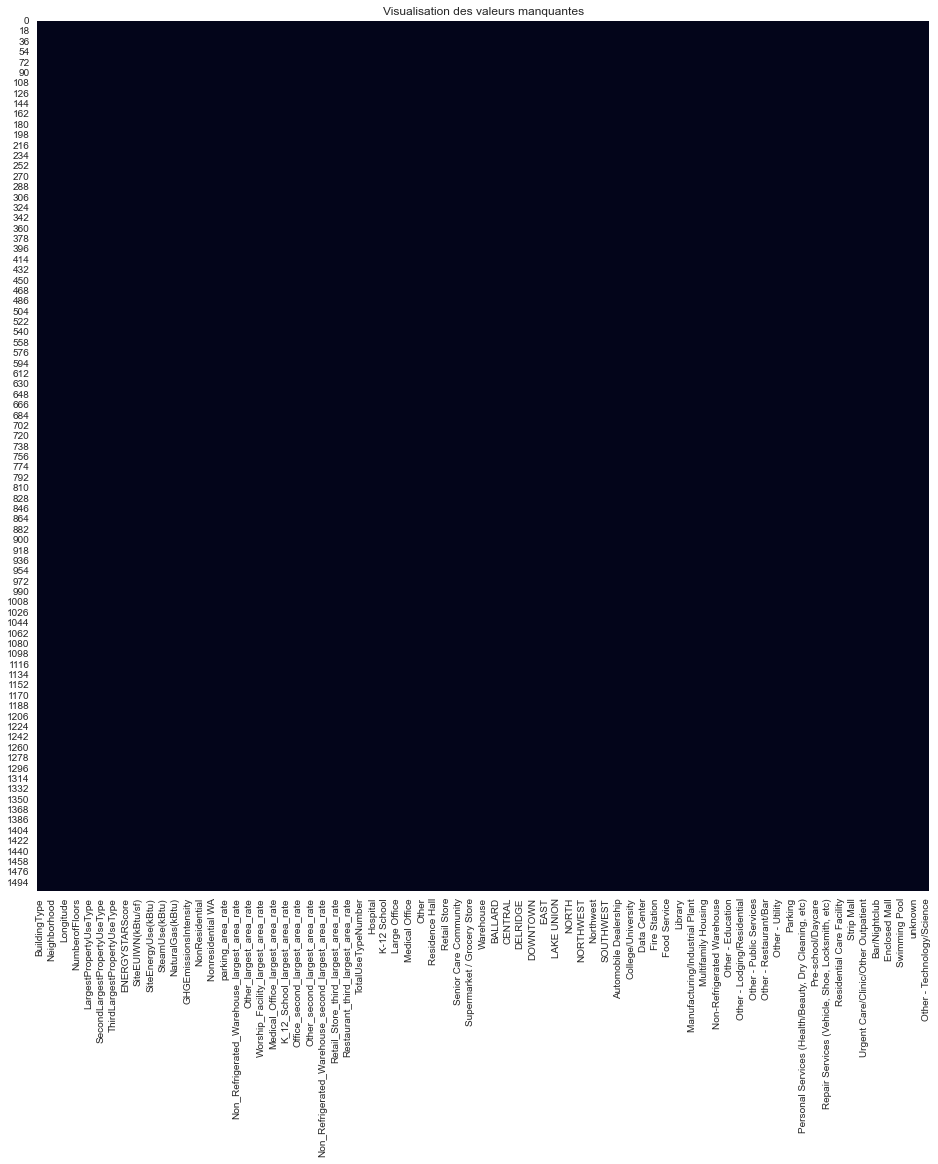

In [209]:
missng_values(data)

In [210]:
data.to_csv("data_cleaned_P4.csv")